# Method of Manufactured Solutions (MMS) for EBA

## Test additional terms in advection-diffusion equation

Two-dimensional, compressible, bottom heated, steady isoviscous thermal convection in a 1 x 1 box, see case 1 of [King et al. (2009)](https://doi.org/10.1111/j.1365-246X.2009.04413.x) / [Blankenbach et al. (1989) benchmark](https://academic.oup.com/gji/article/98/1/23/622167).

Keywords: Extended Boussinesq Approximation, EBA, Convection


In [1]:
import petsc4py
from petsc4py import PETSc

import underworld3 as uw
from underworld3.systems import Stokes
from underworld3 import function

import os 
import numpy as np
import sympy
from sympy.vector import gradient, divergence, dot

### Set parameters to use 

In [2]:
Di = 0.8 # dissipation factor - FIXME: in terms of the physical parameters or do some checks on the physical meanings
Ra = 1e4 #### Rayleigh number

# other non-dimensional parameters
rho_k = 0.5 # use this to set the rho reference and the analytical velocity field

k = 1.0 #### diffusivity

boxLength = 1.0
boxHeight = 1.0
tempMin   = 0.
tempMax   = 1.
deltaTemp = tempMax - tempMin

viscosity = 1

res= 64                 ### x and y res of box
nsteps = 100            ### maximum number of time steps to run the first model 
epsilon_lr = 1e-8       ### criteria for early stopping; relative change of the Vrms in between iterations  

use_analytical = True   #### set to True to use purely analytical form of source
### only support use_analytical = True

 
use_case = 3
# if set to None - usual case
# if set to 1 - gravity dot u 
# if set to 2 - (Di/Ra)*phi
# if set to 3 - gravity dot u  and (Di/Ra)*phi

sdev_v = 0.1     # standard deviation of Gaussian function for velocity
sdev_T = 0.15   # standard deviation for temperature 


In [3]:
# check the mesh if in a notebook / serial
# allows you to visualise the mesh and the mesh variable
'''FIXME: change this so it's better'''

def plotFig(meshbox, s_field, v_field, s_field_name, save_fname = None, with_arrows = False): 
    """
    s_field - scalar field - corresponds to colors
    v_field - vector field - usually the velocity - 2 components
    """
    if uw.mpi.size == 1:

        import numpy as np
        import pyvista as pv
        import vtk

        pv.global_theme.background = "white"
        pv.global_theme.window_size = [400, 400]
        pv.global_theme.anti_aliasing = None #"ssaa", "msaa", "fxaa", or None
        #pv.global_theme.jupyter_backend = "panel"
        pv.global_theme.smooth_shading = True

        meshbox.vtk("tmp_box_mesh.vtk")
        pvmesh = pv.read("tmp_box_mesh.vtk")

        velocity = np.zeros((meshbox.data.shape[0], 3))
        velocity[:, 0] = uw.function.evaluate(v_field.sym[0], meshbox.data)
        velocity[:, 1] = uw.function.evaluate(v_field.sym[1], meshbox.data)

        #pvmesh.point_data["V"] = velocity / 10

        points = np.zeros((s_field.coords.shape[0], 3))
        points[:, 0] = s_field.coords[:, 0]
        points[:, 1] = s_field.coords[:, 1]

        point_cloud = pv.PolyData(points)

        with meshbox.access():
            point_cloud.point_data[s_field_name] = uw.function.evaluate(s_field.fn, points[:, 0:2])

        # point sources at cell centres
        if meshbox._centroids.shape[0]%4 == 0:
            skip = 4
        elif meshbox._centroids.shape[0]%3 == 0:
            skip = 3
        elif meshbox._centroids.shape[0]%2 == 0:
            skip = 2
        else: 
            skip = 1

        cpoints = np.zeros((meshbox._centroids.shape[0] // skip, 3))
        cpoints[:, 0] = meshbox._centroids[::skip, 0]
        cpoints[:, 1] = meshbox._centroids[::skip, 1]

        cpoint_cloud = pv.PolyData(cpoints)

        # pvstream = pvmesh.streamlines_from_source(
        #     cpoint_cloud,
        #     vectors="V",
        #     integrator_type=2,
        #     integration_direction="forward",
        #     compute_vorticity=False,
        #     max_steps=1000,
        #     surface_streamlines=True,
        # )
 
        pl = pv.Plotter()

        with meshbox.access():
        
            arrow_loc = np.zeros((v_field.coords.shape[0], 3))
            arrow_loc[:, 0:2] = v_field.coords[...]

            arrow_length = np.zeros((v_field.coords.shape[0], 3))
            arrow_length[:, 0] = v_field.data[:, 0]
            arrow_length[:, 1] = v_field.data[:, 1]

        pl = pv.Plotter()

        #pl.add_mesh(pvmesh,'Gray', 'wireframe')

        pl.add_mesh(
            pvmesh, cmap="coolwarm", edge_color="Black",
            show_edges=True, use_transparency=False, opacity=0.2,
        )

      
        if with_arrows:
            pl.add_arrows(arrow_loc, arrow_length, mag=1, opacity=1)
        else:
            pl.add_points(point_cloud, cmap="coolwarm", render_points_as_spheres=True, point_size=6, opacity=1)


        # pl.add_mesh(pvstream, opacity=0.5)
        # pl.add_arrows(arrow_loc2, arrow_length2, mag=1.0e-1)

        # pl.add_points(pdata)

        pl.show(cpos="xy")

        if save_fname is not None:
            #pl.save_graphic(save_fname, dpi = 300)
            pl.image_scale = 3
            pl.screenshot(save_fname) 

        pvmesh.clear_data()
        pvmesh.clear_point_data()
        
        
#plotFig()

In [4]:
''' Functions for analytical solutions '''
import math

def gaussian2d (x, z, sdev = 0.1):
    ''' Normalizing factor is 1 so integral of Gaussian is not 1'''
    expo = (x**2 + z**2)/(2*sdev**2)
    return math.exp(-expo)

def gaussian2d_dx (x, z ,sdev = 0.1):
    ''' First derivative with respect to x'''
    val = (-x/sdev**2)*gaussian2d(x, z, sdev = sdev)
    return val

def gaussian2d_dz (x, z ,sdev = 0.1):
    ''' First derivative with respect to z'''
    val = (-z/sdev**2)*gaussian2d(x, z, sdev = sdev)
    return val

def gaussian2d_dxdx (x, z ,sdev = 0.1):
    ''' Second derivative with respect to x'''
    val = (-1 + (x/sdev)**2)*(1/sdev**2)*gaussian2d(x, z, sdev = sdev)
    return val

def gaussian2d_dzdz (x, z ,sdev = 0.1):
    ''' Second derivative with respect to z'''
    val = (-1 + (z/sdev)**2)*(1/sdev**2)*gaussian2d(x, z, sdev = sdev)
    return val

### Create mesh and variables

In [5]:
meshbox = uw.meshing.UnstructuredSimplexBox(
                                                minCoords=(0.0, 0.0), 
                                                maxCoords=(boxLength, boxHeight), 
                                                cellSize=1.0 /res, 
                                                regular=False, 
                                                qdegree = 3
                                        )

#meshbox = uw.meshing.StructuredQuadBox(minCoords=(0.0, 0.0), maxCoords=(boxLength, boxHeight),  elementRes=(res,res))


Processing gmsh file .meshes/uw_simplexbox_minC(0.0, 0.0)_maxC(1.0, 1.0)_csize0.015625_regFalse.msh
Mesh saved to .meshes/uw_simplexbox_minC(0.0, 0.0)_maxC(1.0, 1.0)_csize0.015625_regFalse.msh.h5


In [6]:
# the non-dimensionalized reference states are defined here
x, z = meshbox.X

v_analytical = uw.discretisation.MeshVariable("V", meshbox, meshbox.dim, degree=2)
t_soln = uw.discretisation.MeshVariable("T", meshbox, 1, degree=3)
t_analytical = uw.discretisation.MeshVariable("To", meshbox, 1, degree=3)
t_diff = uw.discretisation.MeshVariable("diff T", meshbox, 1, degree=3)
str_rate = uw.discretisation.MeshVariable("strain rate", meshbox, 1, degree=3)

# theoretical value of viscous dissipation and adiabatic heating
adiab_heat = uw.discretisation.MeshVariable("adiab heat", meshbox, 1, degree=3)
visc_diss = uw.discretisation.MeshVariable("visc diss", meshbox, 1, degree=3)

source_analytical = uw.discretisation.MeshVariable("Ha", meshbox, 1, degree=3)  

t_diff_calc = uw.systems.Projection(meshbox, t_diff)
t_diff_calc.uw_function = t_soln.sym[0] - t_analytical.sym[0] 


### Advection-Diffusion test (extra terms in conservation of energy equation)
The conservation of energy for the Extended Boussinesq approximation is set as: 
\begin{aligned}
\frac{\partial T}{\partial t} + \vec u \cdot \nabla T + DiwT = k\nabla^2T + \phi \frac{Di}{Ra} + H. \; \; \; (1)
\end{aligned}

To do test with MMS, we set analytical solutions of $T$ and $\vec u$. We set them as: 
\begin{aligned}
T(x, z, t) = G_{\sigma _1}(x, z)t \; \; \; \vec u (x, z) = G_{\sigma _2}(x, z)\hat{i} + G_{\sigma _2}(x, z)\hat{k} \; \; \; (2)
\end{aligned}
Where $G_{\sigma}$ is the un-normalized 2D Gaussian function:
\begin{aligned}
G_{\sigma}(x, z) = exp(-\frac{x^2 + z^2}{2\sigma^2})
\end{aligned}

And we analytically calculate a source term, $H$, as:
\begin{aligned}
H = \frac{\partial T}{\partial t} + \vec u \cdot \nabla T + DiwT - k\nabla^2T - \phi \frac{Di}{Ra}. \; \; \; (3)
\end{aligned}
Then we solve Eq. (1) with source set as $H$. 

In [7]:
# Create adv_diff object

adv_diff = uw.systems.AdvDiffusionSLCN(
    meshbox,
    u_Field=t_soln,
    V_Field=v_analytical,
    solver_name="adv_diff"
)

adv_diff.constitutive_model = uw.systems.constitutive_models.DiffusionModel(meshbox.dim)
adv_diff.constitutive_model.Parameters.diffusivity = k
term3 = -Di*v_analytical.sym[1]*(t_soln.sym[0]) # FIXME: change the variable names

strain_rate = 0.5*(v_analytical.jacobian() + v_analytical.jacobian().T) # the strain rate tensor in terms of the velocities

str_rate_calc = uw.systems.Projection(meshbox, str_rate)
str_rate_calc.uw_function = viscosity*(Di/Ra)*(strain_rate[0, 0]**2 + 2*(strain_rate[0, 1]*strain_rate[1, 0]) + strain_rate[1, 1]**2)
# term5 = str_rate.sym[0]
term5 = viscosity*(Di/Ra)*(strain_rate[0, 0]**2 + 2*(strain_rate[0, 1]*strain_rate[1, 0]) + strain_rate[1, 1]**2)
 
adv_diff.theta = 0.5

# # Dirichlet boundary conditions for temperature
# # note that that Top is now the source of heat - deep in the mantle
# # z = 0 is the surface 
adv_diff.add_dirichlet_bc(0.0, "Bottom")
adv_diff.add_dirichlet_bc(0.0, "Top")
adv_diff.add_dirichlet_bc(0.0, "Left")
adv_diff.add_dirichlet_bc(0.0, "Right")

adv_diff.petsc_options["pc_gamg_agg_nsmooths"] = 5


In [8]:
(strain_rate[0, 0]**2 + 2*(strain_rate[0, 1]*strain_rate[1, 0]) + strain_rate[1, 1]**2)

0.5*(V_{ 0,1}(N0.x, N0.y) + V_{ 1,0}(N0.x, N0.y))**2 + 1.0*V_{ 0,0}(N0.x, N0.y)**2 + 1.0*V_{ 1,1}(N0.x, N0.y)**2

In [8]:
str_rate_calc.uw_function

Matrix([[4.0e-5*(V_{ 0,1}(N0.x, N0.y) + V_{ 1,0}(N0.x, N0.y))**2 + 8.0e-5*V_{ 0,0}(N0.x, N0.y)**2 + 8.0e-5*V_{ 1,1}(N0.x, N0.y)**2]])

In [9]:
term5

4.0e-5*(V_{ 0,1}(N0.x, N0.y) + V_{ 1,0}(N0.x, N0.y))**2 + 8.0e-5*V_{ 0,0}(N0.x, N0.y)**2 + 8.0e-5*V_{ 1,1}(N0.x, N0.y)**2

In [10]:
# create the v_analytical and t_analytical fields
import math 

time_use = 1e-5

with meshbox.access(v_analytical, t_analytical, t_soln):
    # velocity
    for index, coord in enumerate(v_analytical.coords):
        x_c = coord[0] - 0.5
        z_c = coord[1] - 0.5

        v_analytical.data[index, 0] = gaussian2d(x_c, z_c, sdev_v)
        v_analytical.data[index, 1] = gaussian2d(x_c, z_c, sdev_v)

        # rotation with Gaussian mask
        #mask_val = math.exp(-(coord[0]-0.5)**2/(2*sdev_v**2) - (coord[1]-0.5)**2/(2*sdev_v**2))
        #v_analytical.data[index, 0] = -(coord[1] - 0.5)*mask_val
        #v_analytical.data[index, 1] = (coord[0] - 0.5)*mask_val
    
    # temperature - analytical
    for index, coord in enumerate(t_analytical.coords):
        mask_val = math.exp(-(coord[0]-0.5)**2/(2*sdev_T**2) - (coord[1]-0.5)**2/(2*sdev_T**2))
    
        t_analytical.data[index] = mask_val*time_use

    # temperature - solution
    for index, coord in enumerate(t_soln.coords):
        mask_val = math.exp(-(coord[0]-0.5)**2/(2*sdev_T**2) - (coord[1]-0.5)**2/(2*sdev_T**2))

        t_soln.data[index] = 0 #mask_val

# analytical form of the source field
with meshbox.access(source_analytical, visc_diss):

    for index, coord in enumerate(source_analytical.coords):

        x_c = coord[0] - 0.5
        z_c = coord[1] - 0.5
        # derivative of T w.r.t. t
        t1 = gaussian2d(x_c, z_c, sdev_T)

        # dot product of velocity and gradient of T
        t2 = gaussian2d(x_c, z_c, sdev_v)*gaussian2d_dx(x_c, z_c, sdev_T)*time_use + \
            gaussian2d(x_c, z_c, sdev_v)*gaussian2d_dz(x_c, z_c, sdev_T)*time_use
        
        # Di*u_z*T
        t3 = Di*gaussian2d(x_c, z_c, sdev_v)*gaussian2d(x_c, z_c, sdev_T)*time_use

        # k*laplacian of T - adiabatic term
        t4 = k*gaussian2d_dxdx(x_c, z_c, sdev_T)*time_use + gaussian2d_dzdz(x_c, z_c, sdev_T)*time_use
        
        # viscosity dissipation
        t5 = viscosity*(Di/Ra)*(gaussian2d_dx(x_c, z_c, sdev_v)**2 
                                + 0.5*(gaussian2d_dx(x_c, z_c, sdev_v) + gaussian2d_dz(x_c, z_c, sdev_v))**2
                                + gaussian2d_dz(x_c, z_c, sdev_v)**2) 
        
        if use_case is None:
            source_analytical.data[index] = t1 + t2 - t4
        elif use_case == 1:
            source_analytical.data[index] = t1 + t2 + t3 - t4
        elif use_case == 2:
            source_analytical.data[index] = t1 + t2 - t4 - t5
            visc_diss.data[index] = -t5
        elif use_case == 3:
            source_analytical.data[index] = t1 + t2 + t3 - t4 - t5

# calculate discretized strain rate for numerical solution
str_rate_calc.solve()

  0 SNES Function norm 6.04445e-06 
  1 SNES Function norm 4.886e-11 
Nonlinear SProj_2_ solve converged due to CONVERGED_FNORM_RELATIVE iterations 1


In [11]:
Di/Ra

8e-05

In [12]:
str_rate_calc.uw_function

Matrix([[4.0e-5*(V_{ 0,1}(N0.x, N0.y) + V_{ 1,0}(N0.x, N0.y))**2 + 8.0e-5*V_{ 0,0}(N0.x, N0.y)**2 + 8.0e-5*V_{ 1,1}(N0.x, N0.y)**2]])

/Users/jcgraciosa/mambaforge/envs/uw3/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:58: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


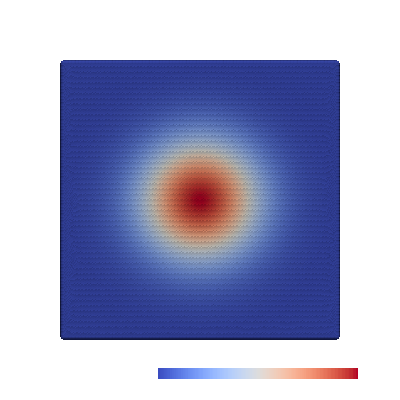

/Users/jcgraciosa/mambaforge/envs/uw3/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:58: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


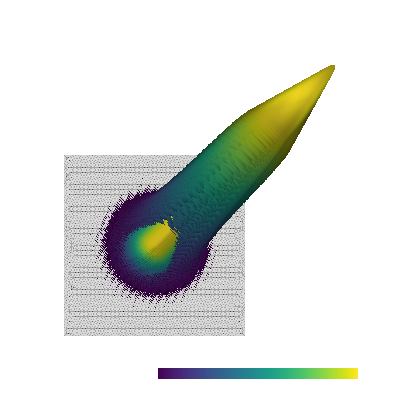

/Users/jcgraciosa/mambaforge/envs/uw3/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:58: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


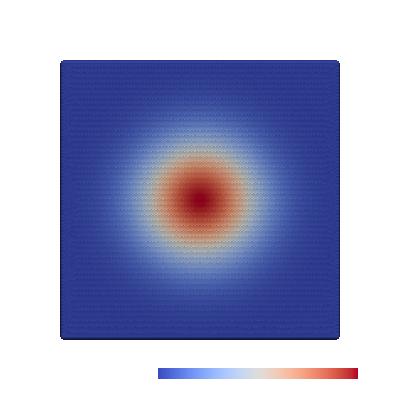

In [13]:
# ugly plotter
plotFig(meshbox, t_analytical, v_analytical, s_field_name = "analytical T", save_fname = None, with_arrows = False)
plotFig(meshbox, t_analytical, v_analytical, s_field_name = "analytical T", save_fname = None, with_arrows = True)

plotFig(meshbox, source_analytical, v_analytical, s_field_name = "Source analytical", save_fname = None, with_arrows = False)

In [14]:
if use_analytical:
    if use_case is None:
        adv_diff.f = source_analytical.sym[0]
    elif use_case == 1:
        adv_diff.f = source_analytical.sym[0] + term3
    elif use_case == 2:
        adv_diff.f = source_analytical.sym[0] + term5
    elif use_case == 3:
        adv_diff.f = source_analytical.sym[0] + term3 + term5

adv_diff.adv_diff_slcn_problem_description() # need to run this? 

In [15]:
# check the equations for the Advection diffusion equation
display(adv_diff.f) # RHS of equation

Matrix([[4.0e-5*(V_{ 0,1}(N0.x, N0.y) + V_{ 1,0}(N0.x, N0.y))**2 + Ha(N0.x, N0.y) - 0.8*T(N0.x, N0.y)*V_{ 1 }(N0.x, N0.y) + 8.0e-5*V_{ 0,0}(N0.x, N0.y)**2 + 8.0e-5*V_{ 1,1}(N0.x, N0.y)**2]])

In [16]:
adv_diff.estimate_dt()

  0 SNES Function norm 0.014417 
  1 SNES Function norm 2.21612e-07 
Nonlinear SProj_3_ solve converged due to CONVERGED_FNORM_RELATIVE iterations 1


8.663516061407034e-06

In [17]:
adv_diff.solve(timestep = 1e-5, zero_init_guess = False)

  0 SNES Function norm 0.00147219 
  1 SNES Function norm 2.80755e-08 
Nonlinear adv_diff_ solve converged due to CONVERGED_FNORM_RELATIVE iterations 1


In [18]:
t_diff_calc.solve()

  0 SNES Function norm < 1.e-11
  1 SNES Function norm < 1.e-11
Nonlinear SProj_1_ solve converged due to CONVERGED_FNORM_RELATIVE iterations 1


/Users/jcgraciosa/mambaforge/envs/uw3/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:58: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


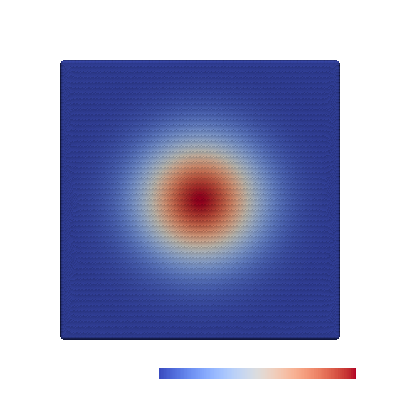

In [19]:
plotFig(meshbox, t_soln, v_analytical, s_field_name = "diff T", save_fname = None, with_arrows = False)

/Users/jcgraciosa/mambaforge/envs/uw3/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:58: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


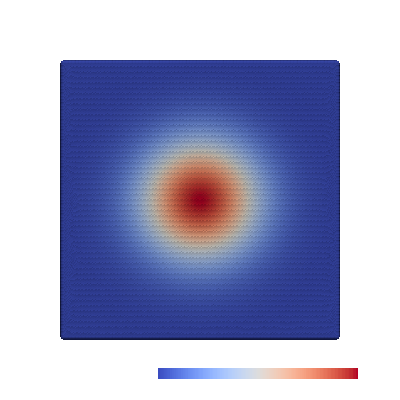

In [20]:
plotFig(meshbox, t_analytical, v_analytical, s_field_name = "analytical T", save_fname = None, with_arrows = False)

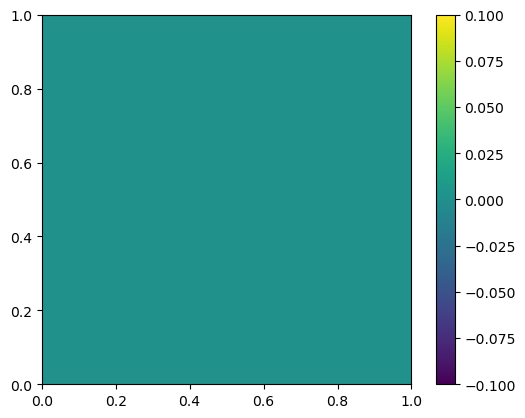

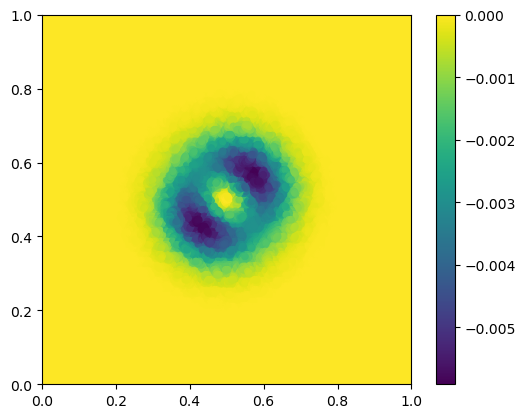

In [21]:
import matplotlib.pyplot as plt
with meshbox.access():
    fig, ax = plt.subplots(dpi = 100)
    out = ax.scatter(visc_diss.coords[:, 0], visc_diss.coords[:, 1], c = visc_diss.data[:], s = 20)
    ax.set_aspect("equal")
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    plt.colorbar(out)
    fig, ax = plt.subplots(dpi = 100)
    out = ax.scatter(str_rate.coords[:, 0], str_rate.coords[:, 1], c =-str_rate.data[:], s = 20)
    ax.set_aspect("equal")
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    plt.colorbar(out)

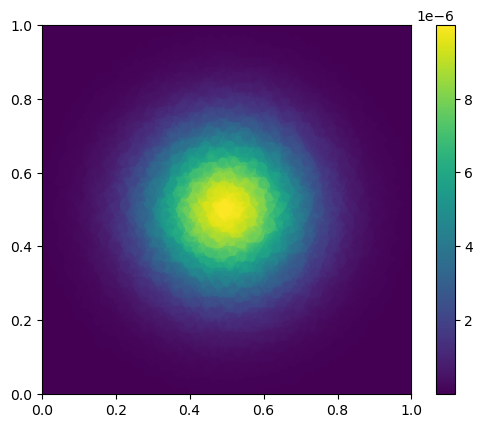

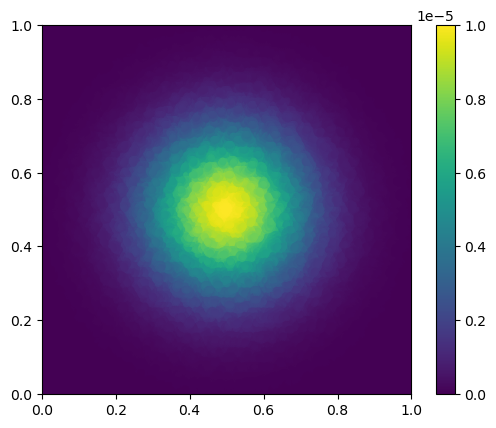

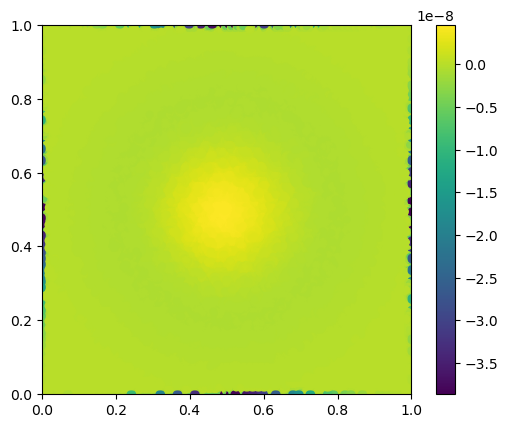

In [22]:
# compare theoretical and numerical solution
import matplotlib.pyplot as plt
with meshbox.access():
    fig, ax = plt.subplots(dpi = 100)
    out = ax.scatter(t_analytical.coords[:, 0], t_analytical.coords[:, 1], c = t_analytical.data[:], s = 20)
    ax.set_aspect("equal")
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    plt.colorbar(out)
    fig, ax = plt.subplots(dpi = 100)
    out = ax.scatter(t_soln.coords[:, 0], t_soln.coords[:, 1], c = t_soln.data[:], s = 20)
    ax.set_aspect("equal")
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    plt.colorbar(out)
    fig, ax = plt.subplots(dpi = 100)
    out = ax.scatter(t_diff.coords[:, 0], t_diff.coords[:, 1], c = t_diff.data[:], s = 20)
    ax.set_aspect("equal")
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    plt.colorbar(out)


In [23]:
adv_diff._f1

Matrix([[0.5*T_{,0}(N0.x, N0.y) + 0.5*\cal{P}\left(T^{*^{{[1]}}}\right)_{,0}(N0.x, N0.y), 0.5*T_{,1}(N0.x, N0.y) + 0.5*\cal{P}\left(T^{*^{{[1]}}}\right)_{,1}(N0.x, N0.y)]])

In [24]:
adv_diff._f0

Matrix([[-4.0e-5*(V_{ 0,1}(N0.x, N0.y) + V_{ 1,0}(N0.x, N0.y))**2 - Ha(N0.x, N0.y) + 0.8*T(N0.x, N0.y)*V_{ 1 }(N0.x, N0.y) + 100000.0*T(N0.x, N0.y) - 8.0e-5*V_{ 0,0}(N0.x, N0.y)**2 - 8.0e-5*V_{ 1,1}(N0.x, N0.y)**2 - 100000.0*\cal{P}\left(T^{*^{{[1]}}}\right)(N0.x, N0.y)]])

In [25]:
with meshbox.access():
    val = t_diff.data**2

print(val.mean())

7.886572749963925e-18


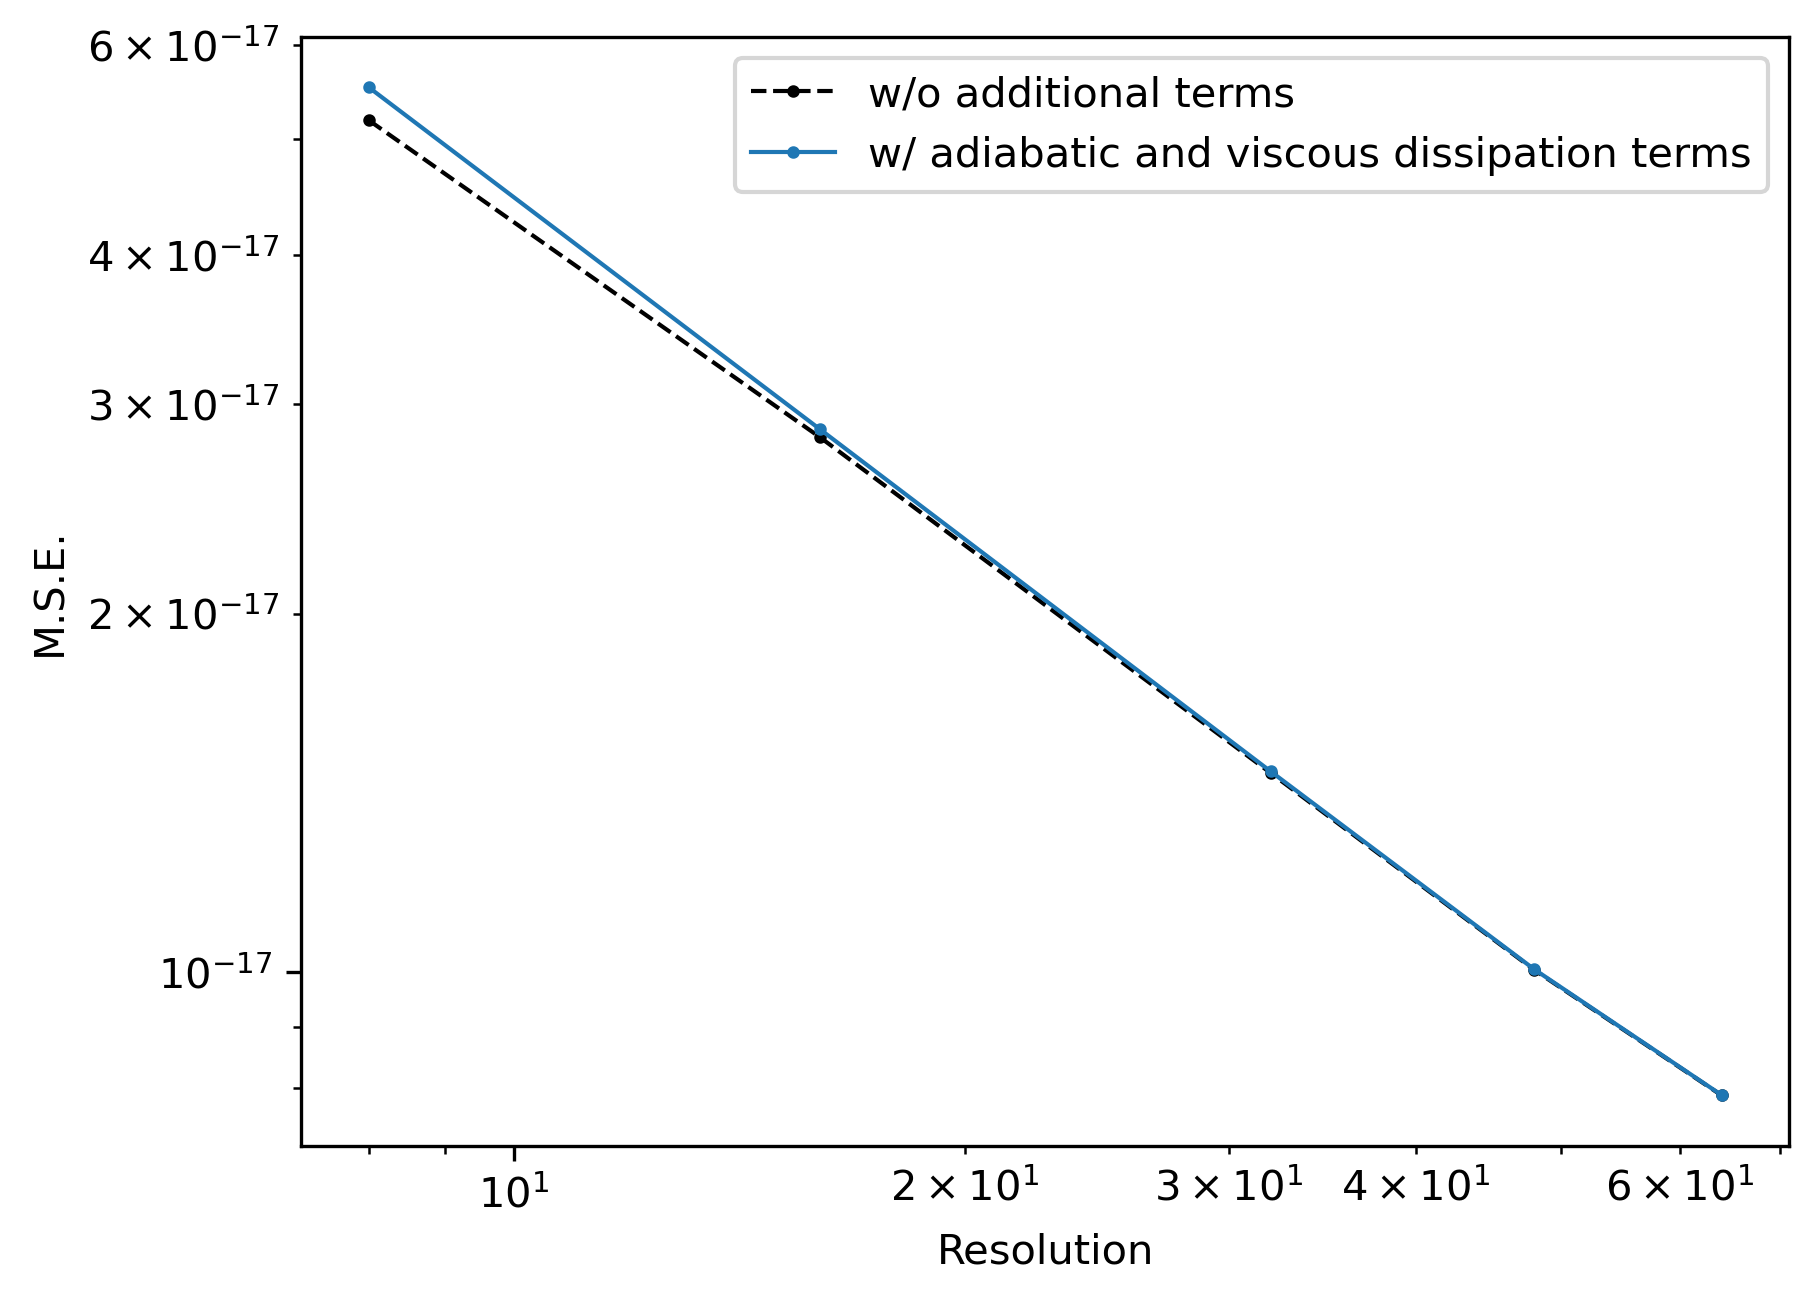

In [28]:
res_list = np.array([8, 16, 32, 48, 64])
# modified version
baseline = np.array([5.1873123276007105e-17, 2.812350533431548e-17, 1.4695052283679355e-17, 1.0041344203500364e-17, 7.881884979108032e-18])
t3_add = np.array([5.188944517937402e-17, 2.81405397055817e-17, 1.4712884913535934e-17, 1.0059119482758e-17, 7.899914698120668e-18])
t5_add = np.array([5.528430698880942e-17, 2.8562542293467914e-17, 1.4740580941983433e-17, 1.0052959194501376e-17, 7.886578623375263e-18])
t3t5_add = np.array([5.528428431128679e-17, 2.856253477715102e-17, 1.474057063749934e-17, 1.0052952615743296e-17, 7.886572749963925e-18])

# old version
# baseline = np.array([5.1869528020676933e-17, 2.812350798425142e-17, 1.4695045767842682e-17, 1.004137630075173e-17, 7.882060967766226e-18])
# t1t2_add = np.array([1.0866446718756127e-16, 8.905377390221873e-17, 7.807905517264899e-17, 7.38258893189316e-17, 7.242055546524207e-17])

import matplotlib.pyplot as plt

fig, ax = plt.subplots(dpi = 300)
ax.plot(res_list, baseline, "o--", color = "k", linewidth = 1, markersize = 2,label = "w/o additional terms")
ax.plot(res_list, t3t5_add, "o-", linewidth = 1, markersize =2, label = "w/ adiabatic and viscous dissipation terms")
ax.legend()
ax.set_xlabel("Resolution")
ax.set_ylabel("M.S.E.")
ax.set_yscale("log")
ax.set_xscale("log")

outfile = "/Users/jcgraciosa/Documents/codes/uw3-dev/King_benchmark/out_plots/mms_eba.png"
plt.savefig(outfile)

In [ ]:
np.polyfit(np.log(res_list), np.log(baseline), 1)

array([ -0.91314835, -35.59209007])